In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import os
import requests

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(1337)
if device == 'cuda':
    torch.cuda.manual_seed(1337)

Using device: cuda


In [2]:
@torch.jit.script
def hope_scan(k, v, q, initial_state, eta, beta):
    """
    Fused kernel for the HOPE Memory Update.
    
    k, v, q: (Batch, Seq, Head_Dim)
    initial_state: (Batch, Head_Dim, Head_Dim)
    eta: Learning Rate for the inner loop
    beta: Forgetting factor
    """
    b, t, d = k.shape
    
    # Initialize state
    state = initial_state # (B, D, D)
    outputs = torch.jit.annotate(torch.Tensor, torch.zeros(b, t, d, device=k.device))
    
    # Iterate over sequence
    for i in range(t):
        k_t = k[:, i].unsqueeze(2) # (B, D, 1)
        v_t = v[:, i].unsqueeze(2)
        q_t = q[:, i].unsqueeze(2)
        
        # 1. Query Memory (Pre-update prediction)
        # y = M * q
        y_t = torch.bmm(state, q_t)
        outputs[:, i] = y_t.squeeze(2)
        
        # 2. Update Memory State (Inner Optimization Step)
        # Prediction: v_pred = M * k
        v_pred = torch.bmm(state, k_t)
        
        # Error: e = v - v_pred
        error = v_t - v_pred
        
        # Gradient/Delta: delta = error * k.T
        delta = torch.bmm(error, k_t.transpose(1, 2))
        
        # Update Rule: M_new = Beta * M_old + Eta * Delta
        state = (beta * state) + (eta * delta)
        
    return outputs

In [3]:
class HOPEAttention(nn.Module):
    def __init__(self, dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        self.num_heads = dim // head_dim
        
        # Multi-head projections
        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.out_proj = nn.Linear(dim, dim, bias=False)
        
        self.norm = nn.LayerNorm(dim)
        
        # Learnable inner-loop parameters (broadcastable)
        self.eta = nn.Parameter(torch.ones(self.num_heads, 1, 1) * 0.5)
        self.beta = nn.Parameter(torch.ones(self.num_heads, 1, 1) * 0.95)
        
    def forward(self, x):
        B, T, C = x.shape
        x_norm = self.norm(x)
        
        # Project and reshape heads
        q = self.q_proj(x_norm).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x_norm).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x_norm).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Normalize K for stable outer product projection
        k = k / (torch.norm(k, dim=-1, keepdim=True) + 1e-6)
        
        # Reshape for parallel scan: merge Batch and Heads -> (B*Heads, T, D)
        q_flat = q.reshape(B * self.num_heads, T, self.head_dim)
        k_flat = k.reshape(B * self.num_heads, T, self.head_dim)
        v_flat = v.reshape(B * self.num_heads, T, self.head_dim)
        
        # Initial State M_0 (Zero initialization works well)
        initial_state = torch.zeros(B * self.num_heads, self.head_dim, self.head_dim, device=x.device)
        
        # Expand meta-params for scan
        eta_flat = self.eta.repeat(B, 1, 1)
        beta_flat = self.beta.repeat(B, 1, 1)
        
        # Run JIT Scan
        out_flat = hope_scan(k_flat, v_flat, q_flat, initial_state, eta_flat, beta_flat)
        
        # Reshape back to (B, T, C)
        out = out_flat.view(B, self.num_heads, T, self.head_dim).transpose(1, 2).reshape(B, T, C)
        
        return self.out_proj(out) + x

class CMSBlock(nn.Module):
    """
    Simplified Continuum Memory System.
    Uses Gating to simulate the selection of "Fast" vs "Slow" information flow.
    """
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.w1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.w2 = nn.Linear(hidden_dim, dim)
        self.gate = nn.Linear(dim, dim)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        
        # Gating mechanism controls information flow
        gate = torch.sigmoid(self.gate(x))
        h = self.act(self.w1(x))
        out = self.w2(h)
        
        return residual + (out * gate)

In [4]:
class PracticalHOPE(nn.Module):
    def __init__(self, vocab_size, dim=256, depth=4, head_dim=32):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Embedding(512, dim) # Simple positional enc
        
        self.layers = nn.ModuleList([
            nn.ModuleList([
                HOPEAttention(dim, head_dim),
                CMSBlock(dim, dim * 4)
            ])
            for _ in range(depth)
        ])
        
        self.norm_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # Embeddings
        tok_emb = self.emb(idx)
        # Ensure pos_emb doesn't error if T > 512 (clamp or modulo for safety in this demo)
        safe_T = torch.arange(T, device=idx.device) % 512
        pos_emb = self.pos_emb(safe_T)
        x = tok_emb + pos_emb
        
        for attn, cms in self.layers:
            x = attn(x)
            x = cms(x)
            
        x = self.norm_f(x)
        logits = self.head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        # Generation loop
        for _ in range(max_new_tokens):
            # Crop to context size to prevent index errors
            idx_cond = idx[:, -256:] 
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [5]:
# Download Tiny Shakespeare
file_path = 'tinyshakespeare.txt'
if not os.path.exists(file_path):
    print("Downloading Tiny Shakespeare...")
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(file_path, 'r') as f:
    text = f.read()

# Create Vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocab Size: {vocab_size}")
print(f"Total Characters: {len(text)}")

# Mappings
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Convert to Tensor
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

Vocab Size: 65
Total Characters: 1115394


In [12]:
# Hyperparameters
BATCH_SIZE = 64
BLOCK_SIZE = 128  # Context length
MAX_ITERS = 100  # Training steps
EVAL_INTERVAL = 200
LEARNING_RATE = 3e-4
DIM = 192
DEPTH = 6
HEAD_DIM = 32

# Init Model
model = PracticalHOPE(vocab_size, dim=DIM, depth=DEPTH, head_dim=HEAD_DIM)
model.to(device)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

Model Parameters: 3.01M


In [13]:
def get_batch(split):
    data_src = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_src) - BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([data_src[i:i+BLOCK_SIZE] for i in ix])
    y = torch.stack([data_src[i+1:i+BLOCK_SIZE+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(50)
        for k in range(50):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [14]:
start_time = time.time()
print("Starting training...")

for iter in range(MAX_ITERS):
    # Every few steps, evaluate loss on train and val sets
    if iter % EVAL_INTERVAL == 0 or iter == MAX_ITERS - 1:
        losses = estimate_loss()
        print(f"Step {iter}: Train Loss {losses['train']:.4f}, Val Loss {losses['val']:.4f}")
        
    # Sample a batch of data
    xb, yb = get_batch('train')
    
    # Evaluate the loss
    _, loss = model(xb, yb)
    
    # Backprop
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    
    # Clip gradients (Important for Recurrent/HOPE models)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()

print(f"Training finished in {time.time() - start_time:.2f}s")

Starting training...
Step 0: Train Loss 4.2357, Val Loss 4.2331
Step 99: Train Loss 2.1179, Val Loss 2.1479
Training finished in 79.28s


In [15]:
print("--- Generating Text ---")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
out_ids = model.generate(context, max_new_tokens=500)
print(decode(out_ids[0].tolist()))

--- Generating Text ---

And thek bridcowiang is s, be madisen bube die.
Shgr-3 SM:

Yarduss:
Wart he uwqur, vetbaredX
Andanes wich my fefnstarum onoun
Youns, tof is heilt mil; dill, bes ifeets, hain lat Heacd ov the and
Wingnery inerjes!
elplind me litther, cecriuy: that aiss hawhy.

So PUSIG
Bodpeen ave whomery wod mothake onWinou whdrCeiib3
I'le m&omerive ceeshien sto-of gie-xome

Ankand thrugh f son; igDer m:
Ethan inle ofthef fiPre?

KIS? INrHKINLuk!

Hidd&is:
Sadaal the Eand to din couk ay andy Iry to chan tEdealy


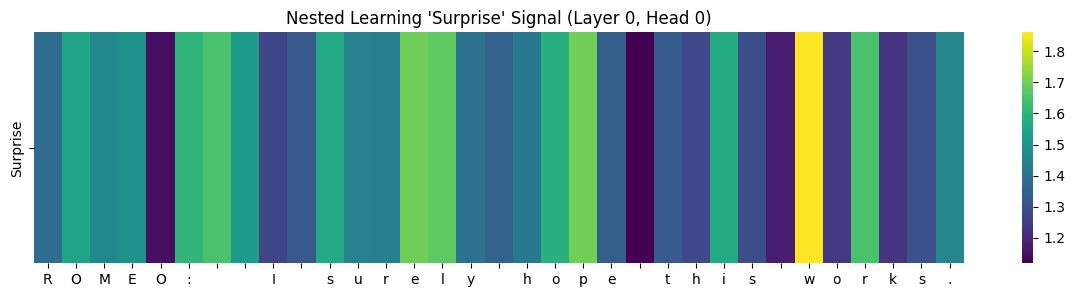

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_surprise(model, text_str):
    model.eval()
    
    # 1. Prepare Input
    device = next(model.parameters()).device
    
    # Check for characters not in vocab to prevent crash
    # (Tiny Shakespeare might not have some special chars)
    valid_chars = [c for c in text_str if c in stoi]
    if len(valid_chars) < len(text_str):
        print("Warning: Some characters were not in the vocabulary and were skipped.")
    
    encoded_ids = encode("".join(valid_chars))
    idx = torch.tensor(encoded_ids, dtype=torch.long, device=device).unsqueeze(0)
    
    # 2. Hook into the model to capture the "Surprise" (Error)
    target_layer = model.layers[0][0] 
    
    with torch.no_grad():
        # --- FIX: Unpack only Batch and Time (B, T) ---
        B, T = idx.shape 
        
        # Embed
        tok_emb = model.emb(idx)
        safe_T = torch.arange(T, device=device) % 512
        pos_emb = model.pos_emb(safe_T)
        x = tok_emb + pos_emb
        x_norm = target_layer.norm(x)
        
        # Projections
        q = target_layer.q_proj(x_norm).view(B, T, target_layer.num_heads, target_layer.head_dim).transpose(1, 2)
        k = target_layer.k_proj(x_norm).view(B, T, target_layer.num_heads, target_layer.head_dim).transpose(1, 2)
        v = target_layer.v_proj(x_norm).view(B, T, target_layer.num_heads, target_layer.head_dim).transpose(1, 2)
        k = k / (torch.norm(k, dim=-1, keepdim=True) + 1e-6)

        # Python-side simulation of the scan to capture 'error'
        head_idx = 0
        k_h = k[0, head_idx] # (T, D)
        v_h = v[0, head_idx]
        q_h = q[0, head_idx]
        
        state = torch.zeros(target_layer.head_dim, target_layer.head_dim, device=device)
        surprises = []
        
        eta = target_layer.eta[head_idx, 0, 0]
        beta = target_layer.beta[head_idx, 0, 0]
        
        for t in range(T):
            kt = k_h[t].unsqueeze(1)
            vt = v_h[t].unsqueeze(1)
            
            # Predict
            v_pred = torch.mm(state, kt)
            
            # Calculate Error Magnitude (Surprise)
            error = vt - v_pred
            surprise_mag = torch.norm(error).item()
            surprises.append(surprise_mag)
            
            # Update (Replicating the JIT kernel logic)
            delta = torch.mm(error, kt.t())
            state = (beta * state) + (eta * delta)

    # 3. Plot
    chars = list("".join(valid_chars))
    plt.figure(figsize=(15, 3))
    sns.heatmap([surprises], xticklabels=chars, yticklabels=['Surprise'], cmap="viridis", cbar=True)
    plt.title(f"Nested Learning 'Surprise' Signal (Layer 0, Head 0)")
    plt.show()

# Run visualization
sample_text = "ROMEO: \nI surely hope this works."
visualize_surprise(model, sample_text)